# Elecciones Federación de Estudiantes Universidad Mayor 2020-2021

## Introducción
Este cuaderno contiene código para obtener, procesar y visualizar datos de las elecciones realizadas por estudiantes de la Universidad Mayor para elegir a sus representantes.

Los datos se encuentran disponibles a través de la API pública de evoting.cl, plataforma de voto electrónico en la que se han realizado todas las elecciones federativas a la fecha.

## Código

In [2]:
import json
import requests
import pandas as pd
from datetime import datetime, timedelta

### API Evoting
La API de evoting contiene dos categorías relevantes para el análisis cuantitativo de las votaciones: ``snapshot``, con los datos de participación de cada carrera, y ``votesByHour``, con la cantidad de votos para cada hora dentro del rango de tiempo en el que fue posible votar.

In [3]:
def get_votes_by_program(election_code: str):
    r = requests.get('https://public-api.evoting.cl/api/election/' + election_code + '/snapshot').json()
    return r

def get_votes_by_hour(election_code: str):
    r = requests.get('https://public-api.evoting.cl/api/election/' + election_code + '/votesByHour').json()
    return r

def get_results(election_code: str):
    r = requests.get('https://public-api.evoting.com/api/election/' + election_code + '/results').json()
    return r

Cada votación tiene un código asignado y quedarán almacenados bajo el nombre de la lista de Mesa Directiva que estuvo postulando en ese momento. Este código debe ser ingresado en la solicitud a evoting para obtener los datos correspondientes.

In [4]:

impulsar_2018 = 'beZd3kuB'
conectemos_2020_1 = 'u1iywcKL'
conectemos_2020_2 = 'dbh0p9bZ'
construyendo_2021 = 'xNUQ8wgx'

program_0 = get_votes_by_program(impulsar_2018)
hour_0 = get_votes_by_hour(impulsar_2018)
program_1 = get_votes_by_program(conectemos_2020_1)
hour_1 = get_votes_by_hour(conectemos_2020_1)
program_2 = get_votes_by_program(conectemos_2020_2)
hour_2 = get_votes_by_hour(conectemos_2020_2)
program_3 = get_votes_by_program(construyendo_2021)
hour_3 = get_votes_by_hour(construyendo_2021)

In [5]:
results_0 = get_results('beZd3kuB')
results_1 = get_results('u1iywcKL')
results_2 = get_results('dbh0p9bZ')
results_3 = get_results('xNUQ8wgx')

### Procesamiento de datos
Los documentos JSON devueltos por evoting se encuentran separados por distrito o por hora, dependiendo de si es una consulta a ``snapshot`` o a ``votesByHour`` respectivamente, y en el caso de la separación por distritos tenemos que cada distrito corresponde a una carrera de la Universidad Mayor que es impartida en Santiago, con una gran cantidad de columnas no utilizadas para cada distrito. Por lo mismo, solo almaceno en un dataframe aquellas columnas que sean relevantes.

Respecto al documento JSON devuelto por ``votesByHour``, las keys corresponden a [tiempos Unix](https://es.wikipedia.org/wiki/Tiempo_Unix), requiriendo una conversión a otro formato de fecha para ser útil.

In [6]:
def create_dataframe_program(input_json):
    districts = []
    for key in input_json['districts']:
        districts.append(str(key))
    df = pd.DataFrame(columns=districts)
    df = df.T
    for district in districts:
        df.loc[district, 'Carrera'] = input_json['districts'][district]['name']
        df.loc[district, 'Votó'] = input_json['districts'][district]['voters']['electronic_voted']
        df.loc[district, 'No votó'] = input_json['districts'][district]['voters']['ready']
    df.style.set_precision(0)
    return df

def create_dataframe_hour(input_json):
    df = pd.DataFrame()
    i = 0
    for hour in input_json['hourly']:
        datetime_hour =  datetime.fromtimestamp(int(hour)) + timedelta(hours=1)
        if (i == 0):
            day = 1
            current_date = datetime_hour.strftime(r'%Y-%m-%d')
        if (current_date != datetime_hour.strftime(r'%Y-%m-%d')):
            day += 1
            current_date = datetime_hour.strftime(r'%Y-%m-%d')
        df.loc[i, 'Día'] = 'Día ' + str(day)
        df.loc[i, 'Fecha'] = datetime_hour.strftime(r'%Y-%m-%d')
        df.loc[i, 'Hora'] =datetime_hour.strftime(r'%H:%M')
        df.loc[i, 'Votos'] = input_json['hourly'][hour]['electronic_voted']
        i = i + 1
    df.style.set_precision(0)
    return df

In [27]:
def create_dataframe_results_positive(input_json):
    df = pd.DataFrame()
    for json in input_json:
        for key in json['questions']:
            if 'edera' in json['questions'][key]['name']:
                df.loc[json['election-id'],'Código Pregunta'] = key
                df.loc[json['election-id'],'Pregunta'] = json['questions'][key]['name']
                #df = df.T
                for district in json['questions'][key]['districts']:
                    for box in json['questions'][key]['districts'][district]['ballotboxes']:
                        #print(json['questions'][key]['districts'][district]['ballotboxes']['BX01']['choices'][0]['total'])
                        name = json['questions'][key]['districts'][district]['name']
                        mapping = [ ('í', 'i'), ('í', 'i'), ('é','e'), ('é','e'), ('ó','o'), ('ó','o'), ('Kinesiologial', 'Kinesiologia'),
                                    ('Pedagogia Educacion Parvularia', 'Pedagogia en Educacion Parvularia')]
                        for k, v in mapping:
                            name = name.replace(k, v)
                        df.loc[json['election-id'],name] = json['questions'][key]['districts'][district]['ballotboxes'][box]['choices'][0]['total']
                        pass
    return df
results = [results_0, results_1, results_2, results_3]
df_results = create_dataframe_results_positive(results)
df_results = df_results.T
df_results.columns = ['Impulsar 2018','Conectemos 2020-1', 'Conectemos 2020-2', 'Construyendo 2021']

def create_dataframe_results_negative(input_json):
    df = pd.DataFrame()
    for json in input_json:
        for key in json['questions']:
            if 'edera' in json['questions'][key]['name']:
                df.loc[json['election-id'],'Código Pregunta'] = key
                df.loc[json['election-id'],'Pregunta'] = json['questions'][key]['name']
                #df = df.T
                for district in json['questions'][key]['districts']:
                    for box in json['questions'][key]['districts'][district]['ballotboxes']:
                        #print(json['questions'][key]['districts'][district]['ballotboxes']['BX01']['choices'][0]['total'])
                        name = json['questions'][key]['districts'][district]['name']
                        mapping = [ ('í', 'i'), ('í', 'i'), ('é','e'), ('é','e'), ('ó','o'), ('ó','o'), ('Kinesiologial', 'Kinesiologia'),
                                    ('Pedagogia Educacion Parvularia', 'Pedagogia en Educacion Parvularia')]
                        for k, v in mapping:
                            name = name.replace(k, v)
                        df.loc[json['election-id'],name] = json['questions'][key]['districts'][district]['ballotboxes'][box]['choices'][1]['total']
                        pass
    return df
df_negative = create_dataframe_results_negative(results)
df_negative = df_negative.T
df_negative.columns = ['Impulsar 2018','Conectemos 2020-1', 'Conectemos 2020-2', 'Construyendo 2021']

In [8]:
df_program_0 = create_dataframe_program(program_0)
df_hour_0 = create_dataframe_hour(hour_0)
df_program_1 = create_dataframe_program(program_1)
df_hour_1 = create_dataframe_hour(hour_1)
df_program_2 = create_dataframe_program(program_2)
df_hour_2 = create_dataframe_hour(hour_2)
df_program_3 = create_dataframe_program(program_3)
df_hour_3 = create_dataframe_hour(hour_3)

In [9]:
pd.set_option('precision',0) # Configura cada columna numérica para aparecer como un entero

In [10]:
df_program_0

,Carrera,Votó,No votó
D01,Alameda,393,549
D02,Conservatorio,48,169
D03,Oriente,99,514
D04,El Claustro,117,797
D05,Huechuraba,1798,3059
D06,Manuel Montt,727,3675
D07,República,62,190
D08,Santo Domingo,140,148
D09,Estadio Mayor,123,355
D10,Alonso de Córdova,0,31


In [11]:
df_program_1

,Carrera,Votó,No votó
D01,Administración Pública,0,23
D02,Agronomía,112,491
D03,Animación Digital,80,171
D04,Arquitectura,151,289
D05,Bachillerato en Ciencias,1,4
D06,Bachillerato en Ciencias de la Salud,8,111
D07,Bachillerato en Humanidades,1,8
D08,Biotecnología,107,89
D09,Cine,82,107
D10,Conservatorio,13,197


In [12]:
df_program_2

,Carrera,Votó,No votó
D01,Administración Pública,0,23
D02,Agronomía,30,566
D03,Animación Digital,128,121
D04,Arquitectura,53,384
D05,Bachillerato en Ciencias,0,5
D06,Bachillerato en Ciencias de la Salud,2,114
D07,Bachillerato en Humanidades,1,8
D08,Biotecnología,44,150
D09,Cine,79,110
D10,Conservatorio,4,201


In [13]:
df_program_3.sort_values(by='Carrera')

,Carrera,Votó,No votó
D19,Agronomía,7,640
D07,Animación Digital,74,215
D20,Arquitectura,4,469
D21,Bachillerato en Ciencias,0,15
D22,Bachillerato en Ciencias de la Salud,0,70
D23,Bachillerato en Humanidades,0,9
D24,Biotecnología,21,200
D13,Cine,71,176
D25,Conservatorio,0,65
D26,Construcción Civil,0,190


In [14]:
df_hour_0

,Día,Fecha,Hora,Votos
0,Día 1,2018-10-08,11:00,155
1,Día 1,2018-10-08,12:00,231
2,Día 1,2018-10-08,13:00,220
3,Día 1,2018-10-08,14:00,176
4,Día 1,2018-10-08,15:00,99
5,Día 1,2018-10-08,16:00,98
6,Día 1,2018-10-08,17:00,101
7,Día 1,2018-10-08,18:00,68
8,Día 1,2018-10-08,19:00,79
9,Día 1,2018-10-08,20:00,95


In [15]:
df_hour_1

,Día,Fecha,Hora,Votos
0,Día 1,2020-06-08,10:00,107
1,Día 1,2020-06-08,11:00,238
2,Día 1,2020-06-08,12:00,309
3,Día 1,2020-06-08,13:00,378
4,Día 1,2020-06-08,14:00,285
5,Día 1,2020-06-08,15:00,188
6,Día 1,2020-06-08,16:00,213
7,Día 1,2020-06-08,17:00,195
8,Día 1,2020-06-08,18:00,158
9,Día 1,2020-06-08,19:00,140


In [16]:
df_hour_2

,Día,Fecha,Hora,Votos
0,Día 1,2020-08-13,10:00,117
1,Día 1,2020-08-13,11:00,120
2,Día 1,2020-08-13,12:00,184
3,Día 1,2020-08-13,13:00,286
4,Día 1,2020-08-13,14:00,225
5,Día 1,2020-08-13,15:00,235
6,Día 1,2020-08-13,16:00,224
7,Día 1,2020-08-13,17:00,202
8,Día 1,2020-08-13,18:00,157
9,Día 1,2020-08-13,19:00,161


In [17]:
df_hour_3

,Día,Fecha,Hora,Votos
0,Día 1,2021-07-19,09:00,21
1,Día 1,2021-07-19,10:00,66
2,Día 1,2021-07-19,11:00,100
3,Día 1,2021-07-19,12:00,105
4,Día 1,2021-07-19,13:00,97
5,Día 1,2021-07-19,14:00,128
6,Día 1,2021-07-19,15:00,73
7,Día 1,2021-07-19,16:00,81
8,Día 1,2021-07-19,17:00,61
9,Día 1,2021-07-19,18:00,59


In [18]:
df_results = df_results.drop('Código Pregunta')
df_results = df_results.drop('Pregunta')
df_results


,Impulsar 2018,Conectemos 2020-1,Conectemos 2020-2,Construyendo 2021
Alameda,4e+02,NaN,NaN,NaN
Conservatorio,4e+01,1e+01,4,0
Oriente,9e+01,NaN,NaN,NaN
El Claustro,1e+02,NaN,NaN,NaN
Huechuraba,2e+03,NaN,NaN,NaN
...,...,...,...,...
Teatro,NaN,6e+01,8,3e+01
Tecnologia Medica,NaN,3e+02,2e+02,2e+02
Terapia Ocupacional,NaN,2e+02,2e+02,7e+01
Ingenieria Comercial,NaN,NaN,NaN,3e+01


## Visualización de los datos

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)})
sns.set_palette("tab10")

### Total de participación para cada elección

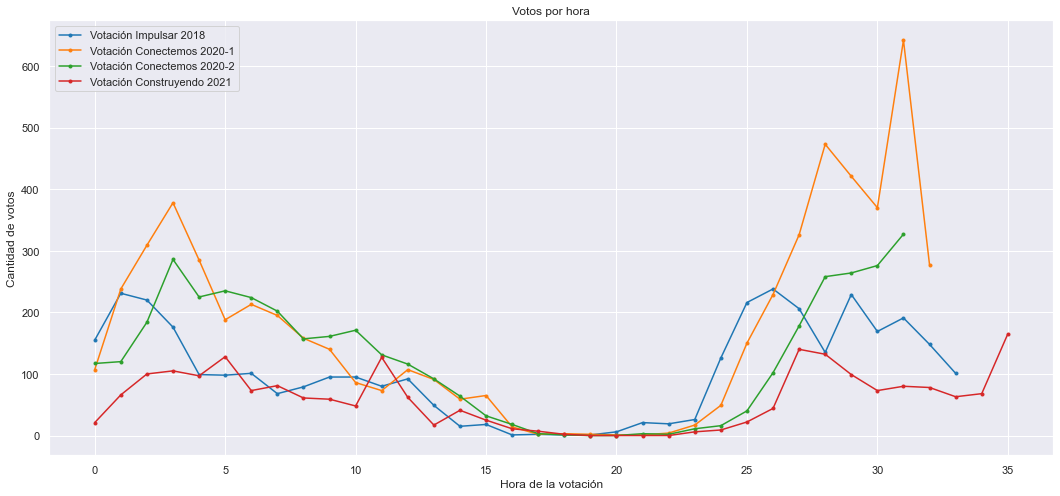

In [20]:
start, end = '0', '35'
fig, ax = plt.subplots()
ax.plot(df_hour_0['Votos'], label='Votación Impulsar 2018', marker='.')
ax.plot(df_hour_1['Votos'], label='Votación Conectemos 2020-1', marker='.')
ax.plot(df_hour_2['Votos'], label='Votación Conectemos 2020-2', marker='.')
ax.plot(df_hour_3['Votos'], label='Votación Construyendo 2021', marker='.')
ax.set_xlabel('Hora de la votación')
ax.set_ylabel('Cantidad de votos')
ax.legend()
ax.set_title('Votos por hora')
plt.show()

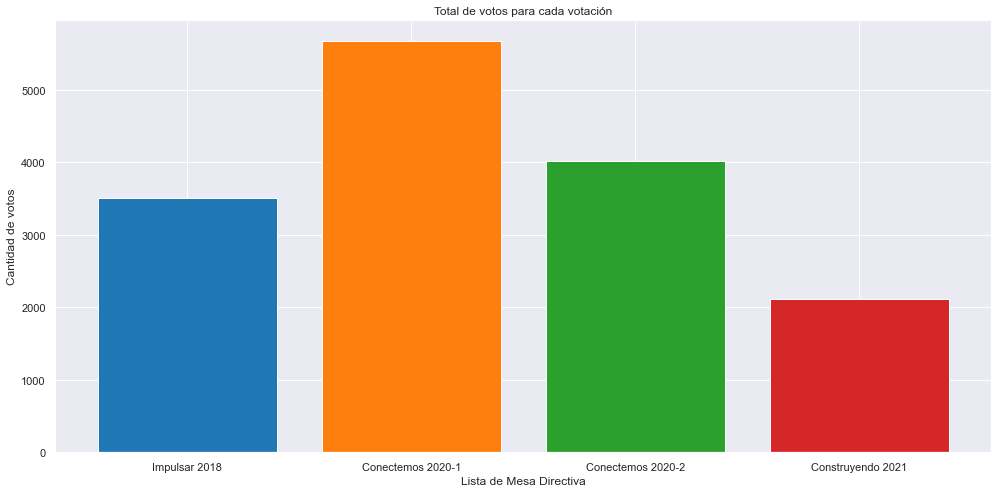

In [21]:
sns.set(rc={'figure.figsize':(13,6)})
sns.set_palette("tab10")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar('Impulsar 2018', df_hour_0['Votos'].sum())
ax.bar('Conectemos 2020-1', df_hour_1['Votos'].sum())
ax.bar('Conectemos 2020-2', df_hour_2['Votos'].sum())
ax.bar('Construyendo 2021', df_hour_3['Votos'].sum())
ax.set_xlabel('Lista de Mesa Directiva')
ax.set_ylabel('Cantidad de votos')
ax.set_title('Total de votos para cada votación')
plt.show()

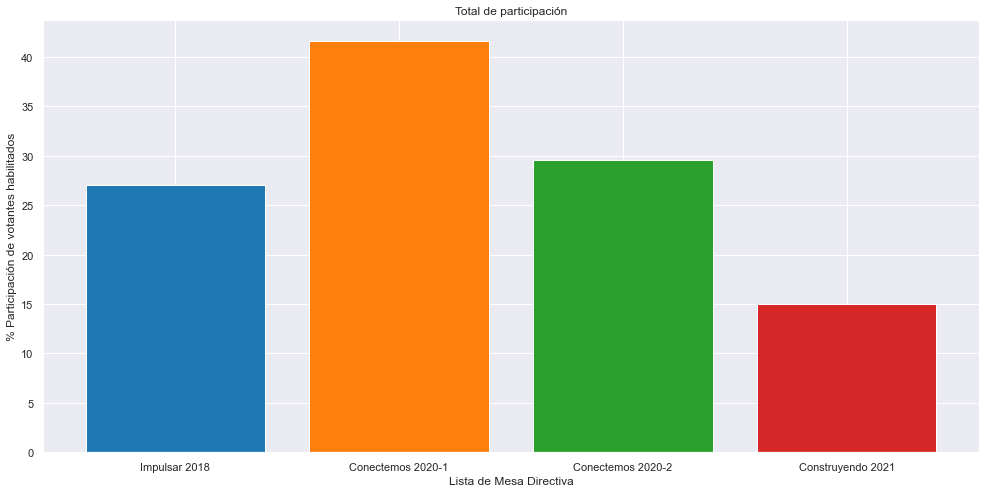

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar('Impulsar 2018', 100*df_program_0['Votó'].sum()/(df_program_0['Votó'].sum()+df_program_0['No votó'].sum()))
ax.bar('Conectemos 2020-1', 100*df_program_1['Votó'].sum()/(df_program_1['Votó'].sum()+df_program_1['No votó'].sum()))
ax.bar('Conectemos 2020-2', 100*df_program_2['Votó'].sum()/(df_program_2['Votó'].sum()+df_program_2['No votó'].sum()))
ax.bar('Construyendo 2021', 100*df_program_3['Votó'].sum()/(df_program_3['Votó'].sum()+df_program_3['No votó'].sum()))
ax.set_xlabel('Lista de Mesa Directiva')
ax.set_ylabel('% Participación de votantes habilitados')
ax.set_title('Total de participación')
plt.show()

In [24]:
ultimas_elecciones = df_results
ultimas_elecciones = ultimas_elecciones.drop('Impulsar 2018', axis=1)
ultimas_elecciones = ultimas_elecciones.drop('Alameda')
ultimas_elecciones = ultimas_elecciones.drop('Oriente')
ultimas_elecciones = ultimas_elecciones.drop('El Claustro')
ultimas_elecciones = ultimas_elecciones.drop('Huechuraba')
ultimas_elecciones = ultimas_elecciones.drop('Manuel Montt')
ultimas_elecciones = ultimas_elecciones.drop('República')
ultimas_elecciones = ultimas_elecciones.drop('Santo Domingo')
ultimas_elecciones = ultimas_elecciones.drop('Estadio Mayor')
ultimas_elecciones = ultimas_elecciones.drop('Alonso de Cordova')
ultimas_elecciones.loc['Ingenieria Comercial', 'Conectemos 2020-2'] = ultimas_elecciones.loc['Ingenieria Comercial - Campus Manuel Montt','Conectemos 2020-2'] + ultimas_elecciones.loc['Ingenieria Comercial - Campus Oriente','Conectemos 2020-2'] 
ultimas_elecciones = ultimas_elecciones.drop('Ingenieria Comercial - Campus Manuel Montt')
ultimas_elecciones = ultimas_elecciones.drop('Ingenieria Comercial - Campus Oriente')
ultimas_elecciones.style.set_precision(0)

,Conectemos 2020-1,Conectemos 2020-2,Construyendo 2021
Conservatorio,13,4,0
Administracion Pública,0,0,nan
Agronomia,52,24,6
Animacion Digital,76,112,58
Arquitectura,125,47,4
Bachillerato en Ciencias,0,0,0
Bachillerato en Ciencias de la Salud,7,2,0
Bachillerato en Humanidades,1,1,0
Biotecnologia,81,32,19
Cine,54,62,50


## Aprobación lista Mesa Directiva (Dos últimas votaciones)

In [25]:
ultimas_elecciones = ultimas_elecciones.dropna()
ultimas_elecciones.style.set_precision(0)

,Conectemos 2020-1,Conectemos 2020-2,Construyendo 2021
Conservatorio,13,4,0
Agronomia,52,24,6
Animacion Digital,76,112,58
Arquitectura,125,47,4
Bachillerato en Ciencias,0,0,0
Bachillerato en Ciencias de la Salud,7,2,0
Bachillerato en Humanidades,1,1,0
Biotecnologia,81,32,19
Cine,54,62,50
Construccion Civil,44,32,0


In [212]:
#for i in if ultimas_elecciones['Conectemos 2020-2']
for i in range(ultimas_elecciones.count()[0]):
    if (ultimas_elecciones['Conectemos 2020-2'][i] < ultimas_elecciones['Construyendo 2021'][i]):
        print(ultimas_elecciones.iloc[i])



Conectemos 2020-2    32.0
Construyendo 2021    56.0
Name: Nutricion y Dietetica, dtype: object
Conectemos 2020-2     8.0
Construyendo 2021    28.0
Name: Teatro, dtype: object
Conectemos 2020-2    20.0
Construyendo 2021    27.0
Name: Ingenieria Comercial, dtype: object


In [29]:

ultimas_elecciones_neg = df_negative
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Impulsar 2018', axis=1)
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Código Pregunta')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Pregunta')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Alameda')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Oriente')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('El Claustro')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Huechuraba')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Manuel Montt')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('República')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Santo Domingo')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Estadio Mayor')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Alonso de Cordova')
ultimas_elecciones_neg.loc['Ingenieria Comercial', 'Conectemos 2020-2'] = ultimas_elecciones_neg.loc['Ingenieria Comercial - Campus Manuel Montt','Conectemos 2020-2'] + ultimas_elecciones_neg.loc['Ingenieria Comercial - Campus Oriente','Conectemos 2020-2'] 
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Ingenieria Comercial - Campus Manuel Montt')
ultimas_elecciones_neg = ultimas_elecciones_neg.drop('Ingenieria Comercial - Campus Oriente')
ultimas_elecciones_neg = ultimas_elecciones_neg.dropna()
ultimas_elecciones_neg.style.set_precision(0)

,Conectemos 2020-1,Conectemos 2020-2,Construyendo 2021
Conservatorio,0,0,0
Agronomia,57,5,0
Animacion Digital,3,13,8
Arquitectura,24,5,0
Bachillerato en Ciencias,1,0,0
Bachillerato en Ciencias de la Salud,1,0,0
Bachillerato en Humanidades,0,0,0
Biotecnologia,16,9,1
Cine,18,10,13
Construccion Civil,18,8,0


In [225]:
array1 = pd.DataFrame.to_numpy(ultimas_elecciones['Conectemos 2020-2'])
array2 = pd.DataFrame.to_numpy(ultimas_elecciones['Construyendo 2021'])
array1

array([4.0, 24.0, 112.0, 47.0, 0.0, 2.0, 1.0, 32.0, 62.0, 32.0, 0.0, 0.0,
       157.0, 37.0, 37.0, 178.0, 101.0, 158.0, 4.0, 37.0, 53.0, 8.0, 22.0,
       131.0, 127.0, 313.0, 32.0, 170.0, 256.0, 58.0, 43.0, 95.0, 99.0,
       58.0, 6.0, 149.0, 45.0, 0.0, 8.0, 200.0, 204.0, 20.0], dtype=object)

<ipython-input-253-df42b17cc226>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ultimas_elecciones.index, rotation=90)
<ipython-input-253-df42b17cc226>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


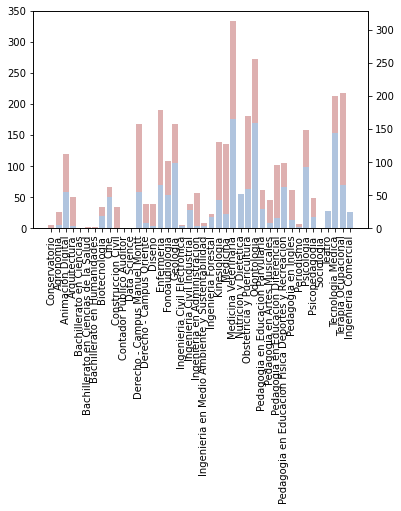

<Figure size 1200x720 with 0 Axes>

In [253]:
#ultimas_elecciones.index
#ultimas_elecciones.plot(x=ultimas_elecciones.index, y=[])
import matplotlib.pyplot as plt
import numpy as np

a = range(0,300)
b = range(0,300)
ind = np.arange(len(a))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ultimas_elecciones.index, array1+0.25, color='#deb0b0', align='center')#, b, 0.45, color='#deb0b0', align='center')

ax2 = ax.twinx()
ax2.bar(ultimas_elecciones.index, array2, color='#b0c4de', align='center') #a, 0.65, color='#b0c4de', align='center')

#plt.xticks(array1, ultimas_elecciones.index, rotation=70)
#plt.setp( ultimas_elecciones.index.get_majorticklabels(), rotation=70 )
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")
ax.set_xticklabels(ultimas_elecciones.index, rotation=90)
plt.ylim(0, 5)
plt.tight_layout()
plt.figure(figsize=(15, 9), dpi=80)
plt.show()

## Créditos
Melissa Silva S. - https://github.com/melipass